# Filter probes that have too strong secondary structures

This notebook takes in an Excel file containing name of the probes and the probe sequence, and outputs probes that need to be discarded due to strong secondary structures.

In [3]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from nupack import *
import matplotlib.pyplot as plt
import pandas as pd

### 1. Example case

In [5]:
my_model = Model(material='dna', celsius=40, sodium=0.3)

# Define strand species
a = Strand('TAGCGAGGGATAGCACAGCCTGGATAGCAAATTACAAAATCGTAGACTCGCTCG', name='a')
c = Complex([a], name = "c")

In [7]:
t1 = Tube(strands={a:5e-7,}, complexes=SetSpec(max_size=1, include=[c]), name='Tube t1')

# Analyze the tube ensemble
# Since pairs is specified, calculate ensemble pair fractions for the tube ensemble
tube_result = tube_analysis(tubes=[t1], compute=['mfe'], model=my_model)
tube_result

Result(tubes={<Tube Tube t1>: <nupack.analysis.TubeResult object at 0x13fc77200>}, complexes=<nupack.analysis.ComplexDict object at 0x13fc38ec0>)

In [9]:
tube_result[c].mfe[0].energy

-2.8842644691467285

### 2. filter probes that have too high |MFE| using the mSpleen_64_gene probe set as an example

In [12]:
df = pd.read_excel("Spleen_64_gene.xlsx")
df.head()

Name                           Final probe
0  Cd8a_pri_1  AGCAGAAATAGTAGCCTTCGTTTTTATTTTTATCTT
1  Cd8a_pri_2      TCTTGTTGTGGGATGAAGCCTATTTTTATCTT
2  Cd8a_pri_3      GTCCACCTTCTGACCAAGTTTATTTTTATCTT
3  Cd8a_pri_4     CCTCATGGCAGAAAACAGTTTTATTTTTATCTT
4  Cd8a_pri_5       CTAGCGGCTGTGGTAGCAGTATTTTTATCTT

In [17]:
with open("Spleen_64_gene.fasta", "w") as fasta_file:
    for index, row in df.iterrows():
        # Create a SeqRecord object for each row in the DataFrame
        probe = row['Final probe']
        if probe.startswith("/5Phos/"): # remove /5Phos/ head on the padlocks
            probe = probe[7:]
        
        seq_record = SeqRecord(Seq(probe), id=row['Name'], description="")
        
        # Write the SeqRecord to the FASTA file
        SeqIO.write(seq_record, fasta_file, "fasta")

In [20]:
Name_list = []
MFE_list = []

# input should be provided in a fasta format
for record in SeqIO.parse("Spleen_64_gene.fasta", "fasta"):
    Name_list.append(record.id)

    a = Strand(str(record.seq), name='a')
    c = Complex([a], name = "c")
    t1 = Tube(strands={a:5e-7,}, complexes=SetSpec(max_size=1, include=[c]), name='Tube t1')
    # Analyze the tube ensemble
    # Since pairs is specified, calculate ensemble pair fractions for the tube ensemble
    tube_result = tube_analysis(tubes=[t1], compute=['mfe'], model=my_model)
    MFE_list.append(tube_result[c].mfe[0].energy)

In [22]:
df = pd.DataFrame({
    'Sequence Name': Name_list,
    'MFE (kcal/mol)': MFE_list})

df_sorted = df.sort_values(by='MFE (kcal/mol)', ascending=True)

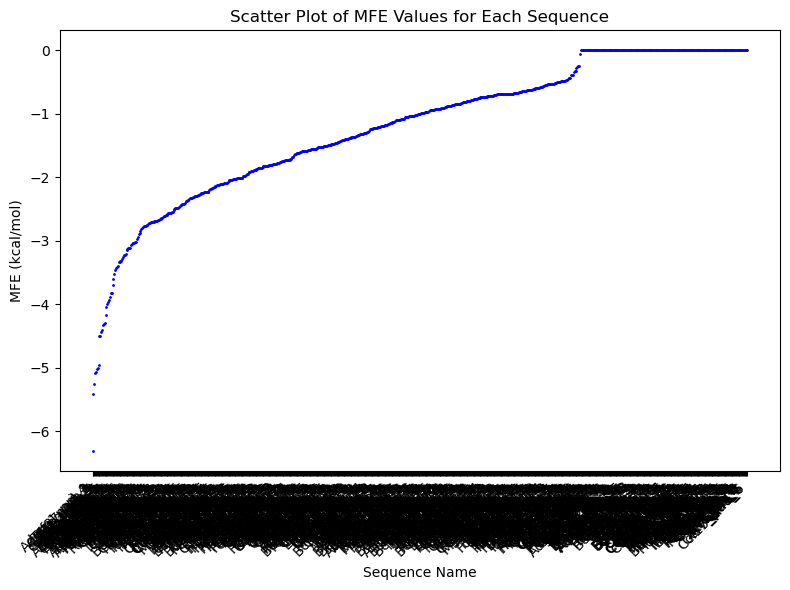

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted["Sequence Name"], df_sorted["MFE (kcal/mol)"], color='blue', s = 1)

plt.xlabel('Sequence Name')
plt.ylabel('MFE (kcal/mol)')
plt.title('Scatter Plot of MFE Values for Each Sequence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [29]:
df_sorted[df_sorted["MFE (kcal/mol)"] < -5]

Sequence Name  MFE (kcal/mol)
225  Adgre1_pri_4       -6.306668
522    Tcf3_pad_3       -5.410033
211    Ccr7_pri_2       -5.251289
613   Csf1r_pad_4       -5.090265
528   Ikzf1_pad_3       -5.075590
482    Lyl1_pad_5       -5.022033
639   Sirpa_pad_4       -5.010344

Probes with |MFE| > 5 kcal/mol have very strong secondary structures and may be filtered out.

**Adgre1_pri_4**
<img src="Adgre1_pri_4.svg" alt="Adgre1_pri_4" width="500"/>

**Csf1r_pad_4**
<img src="Csf1r_pad_4.svg" alt="Adgre1_pri_4" width="500"/>

In [42]:
df_sorted[df_sorted["MFE (kcal/mol)"] < -5].to_excel("Probes_with_strong_2nd_structure.xlsx" ,index=False)